In [14]:
import torch.nn as nn
import torch

from torchvision.models import vit_b_16

from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
import os, sys
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)

In [20]:
download = False

# Download training data from open datasets.
training_data = datasets.MovingMNIST(
    root="data",
    split='train',
    download=download,
#     transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MovingMNIST(
    root="data",
    split='test',
    download=download,
#     transform=ToTensor(),
)

In [33]:
def compute_frame_diff(image_batch):
    
    frame_diff = image_batch[:, 1:, :, :, :] - image_batch[:, :-1, :, :, :]
    
    return frame_diff

In [34]:
image_diff = compute_frame_diff(X)

In [52]:
import importlib, utils
importlib.reload(utils)

<module 'utils' from '/Users/yangjiang/Documents/workspace/src/vision_discrete/utils.py'>

In [66]:

model = Unet(
    dim = 16,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True,
    self_condition = True,
    channels = 1
)

diffusion = utils.GaussianDiffusionDiff(
    model,
    image_size = 64,
    timesteps = 100,    # number of steps,
    objective = 'pred_noise',
    beta_schedule = 'linear'
)


In [67]:
batch_size = 16

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for frames in train_dataloader:

    frames = frames.to(torch.float32)
    
    image_diff = compute_frame_diff(frames)
    prev_images = frames[:, :-1, :, :, :]

    w, h = image_diff.shape[-2], image_diff.shape[-1]
    
    image_diff = torch.reshape(image_diff, (-1, 1, w, h))
    prev_images = torch.reshape(prev_images, (-1, 1, w, h))
    
    b = image_diff.shape[0]
    rand_idx = torch.randperm(b)
    image_diff = image_diff[rand_idx]
    prev_images = prev_images[rand_idx]
        
    loss = diffusion(image_diff, prev_images)
    loss.backward()
    
    break

In [69]:
loss

tensor(56.1683, grad_fn=<MeanBackward0>)

In [ ]:
torch.save(model.state_dict(), PATH)

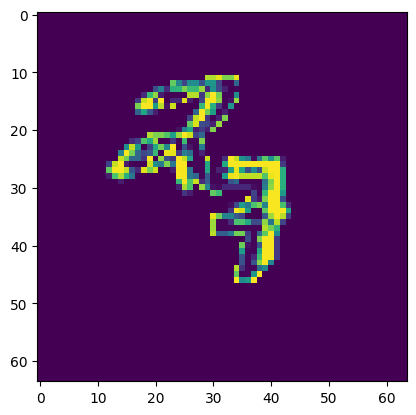

In [37]:
from matplotlib import pyplot as plt
plt.imshow(image_diff[0][2][0], interpolation='nearest')
plt.show()

In [29]:
X[0][0][0].shape


torch.Size([64, 64])